In [1]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [10]:
regret_rsv_dict_list = []
regret_worst_dict_list = []
regret_central_dict_list = []
regret_cstat_dict_list = []
coll_rsv_dict_list = []
coll_worst_dict_list = []

regret_worst_nc_dict_list = []
coll_worst_nc_dict_list = []



# System Parameters
T = 10000
num_users_list = [2,5,10,15,20]
num_svrs_list = [2,5,10,15,20]
num_locs = 9
# mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big
svr_offset_uniform = 2
max_dist = 8

num_explore = 1
trials = 5

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
# svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)

In [4]:
for zt in range(len(num_svrs_list)):
    num_users = num_users_list[zt]
    num_svrs = num_svrs_list[zt]
    # Recording Mechanism
    regret_centralized_dict = {}

    regret_worst_dict = {}
    collisions_worst_dict = {}
    regret_worst_nc_dict = {}
    collisions_worst_nc_dict = {}

    regret_rsv_dict = {}
    collisions_rsv_dict = {}

    regret_cent_stat = {}
    
    mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])


    for tri in range(trials):

        # Build artificial P --> 0.95 Self transition, 0.05/S-1 other transitions
        P = np.zeros(P_collection.shape)

        temp_pm = 0.05

        for i in range(P.shape[0]):
            for j in range(P.shape[0]):
                if i != j:
                    P[i,j] = temp_pm/(P.shape[0]-1)
                else:
                    P[i,j] = 1-temp_pm


        svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs)
#         svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)
        # Create Users
        Users_w = []
        for i in range(num_users):
#             P_temp = P_collection
            Users_w += [User(usr_locs,svr_locs,mu[i],i,
                          max_dist = max_dist, threshold_dist = 6, self_weight = 0.95,
                             P = P, ceiling = 1, sticky_mode = True, kick_mode=True)]
#         Users_w_nc = []
#         for i in range(num_users):
#             Users_w_nc += [User(usr_locs,svr_locs,mu[i],i,
#                           max_dist = 1000000, threshold_dist = 6, self_weight = 0.95,
#                              P = P, ceiling = 1, sticky_mode = True, kick_mode=True)]
        

        # Create Servers
        Servers = []
        for i in range(num_svrs):
            Servers += [Server(svr_locs[i],mu,i)]

        # Recorded Values - reservation
        regret_g = np.zeros(T) # Got
        collision_count_g = np.zeros(T)
        optimal_reward_g = np.zeros(T)

        regret_w = np.zeros(T) # Worst
        collision_count_w = np.zeros(T)
        optimal_reward = np.zeros(T)
        
        regret_w_nc = np.zeros(T)
        collision_count_w_nc = np.zeros(T)

        # Explore rounds are common/shared across all users
        explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                       usr_move_flag = True, rounds=num_explore)
#         explore_rounds(Users_w_nc, num_users, Servers, mu, regret_w_nc, collision_count_w_nc, optimal_reward,
#                        usr_move_flag = True, rounds=num_explore)



        round_start = ((num_svrs)*num_explore)+1


        # Other reward recodings
        Users_rsv = copy.deepcopy(Users_w)
        regret_rsv = copy.deepcopy(regret_w)
        collision_count_rsv = copy.deepcopy(collision_count_w)
        for u in Users_rsv:
            u.sticky_mode = True
            u.kick_mode = True #false
            u.ceiling = ceiling
            u.expected_time_true = u.get_expected_time()
            


        # Centralized - true w learning
        rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_ct = copy.deepcopy(regret_w)

        # Centralized - stationary w learning
        rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_cs = copy.deepcopy(regret_w)

        # Centralized - stationary w, known mu
        w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
        optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
        regret_cst = copy.deepcopy(regret_w)

        for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
            w = obtain_w(Users_w, len(Users_w), len(Servers))
            optimal = offline_optimal_action(w, mu)
            optimal_reward[t] = optimal[1]

            # Distributed solution 
            play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                       usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
            play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                       usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t)
#             play_round(Users_w_nc, Servers, mu, regret_w_nc, collision_count_w_nc, 
#                        usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, w = w)
            copy_usr_loc(Users_w, Users_rsv)
#             copy_usr_loc(Users_w, Users_w_nc)


            # Centralized Solution -  true w learning
            ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
            arms = offline_optimal_action(w, ucb_ct)[0]
            rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
            regret_ct[t] = optimal[1] - expected_reward(arms, mu, w)

            # Centralized Solution -  stationary w learning
            ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
            arms = offline_optimal_action(w_stat, ucb_cs)[0]
            rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
            regret_cs[t] = optimal[1] - expected_reward(arms, mu, w)


        regret_centralized_dict[tri] = copy.deepcopy(regret_ct)

        regret_worst_dict[tri] = copy.deepcopy(regret_w)
        collisions_worst_dict[tri] = copy.deepcopy(collision_count_w)
        
#         regret_worst_nc_dict[tri] = copy.deepcopy(regret_w_nc)
#         collisions_worst_nc_dict[tri] = copy.deepcopy(collision_count_w_nc)

        regret_rsv_dict[tri] = copy.deepcopy(regret_rsv)
        collisions_rsv_dict[tri] = copy.deepcopy(collision_count_rsv)

        regret_cent_stat[tri] = copy.deepcopy(regret_cs)
#         regret_opt_stat[tri] = copy.deepcopy(regret_cst)


        del Users_w, Users_rsv, Servers
    regret_rsv_dict_list += [regret_rsv_dict]
    regret_worst_dict_list += [regret_worst_dict]
    regret_central_dict_list += [regret_centralized_dict]
    regret_cstat_dict_list += [regret_cent_stat]
    coll_rsv_dict_list += [collisions_rsv_dict]
    coll_worst_dict_list += [collisions_worst_dict]

#     regret_worst_nc_dict_list += [regret_worst_nc_dict]
#     coll_worst_nc_dict_list += [collisions_worst_nc_dict]

<ipython-input-4-90c46e30fd54>:102: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):


In [6]:
save_dict = {}
save_dict['regret_rsv_dict_list'] = regret_rsv_dict_list
save_dict['regret_worst_dict_list'] = regret_worst_dict_list
save_dict['regret_central_dict_list'] = regret_central_dict_list
save_dict['regret_cstat_dict_list'] = regret_cstat_dict_list
save_dict['coll_rsv_dict_list'] = coll_rsv_dict_list
save_dict['coll_worst_dict_list'] = coll_worst_dict_list

# save_dict['regret_worst_nc_dict_list'] = regret_worst_nc_dict_list
# save_dict['coll_worst_nc_dict_list'] = coll_worst_nc_dict_list


with open("experiments/save/exp7/220725_run2_t5.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

In [12]:
with open("experiments/save/exp7/220725_run2_t5.pkl", "rb") as handle:
    load_dict = pickle.load(handle)
    
regret_rsv_dict_list = load_dict['regret_rsv_dict_list']
regret_worst_dict_list = load_dict['regret_worst_dict_list']
regret_central_dict_list = load_dict['regret_central_dict_list']
regret_cstat_dict_list = load_dict['regret_cstat_dict_list']

coll_rsv_dict_list = load_dict['coll_rsv_dict_list']
coll_worst_dict_list = load_dict['coll_worst_dict_list']

# regret_worst_nc_dict_list = load_dict['regret_worst_nc_dict_list']
# coll_worst_nc_dict_list = load_dict['coll_worst_nc_dict_list']

In [13]:
nt = trials
cc = len(num_svrs_list)

# calculating error bars
regret_worst_sd = np.zeros([cc,nt])
regret_rsv_sd = np.zeros([cc, nt])
regret_cent_stat_sd = np.zeros([cc, nt])
regret_centralized_sd = np.zeros([cc, nt])

collisions_worst_sd = np.zeros([cc,nt])
collisions_rsv_sd = np.zeros([cc, nt])

for i in range(cc):
    for j in range(nt):
        regret_worst_sd[i,j] = np.cumsum(regret_worst_dict_list[i][j])[-1]
        regret_rsv_sd[i,j] = np.cumsum(regret_rsv_dict_list[i][j])[-1]
        regret_cent_stat_sd[i,j] = np.cumsum(regret_cstat_dict_list[i][j])[-1]
        regret_centralized_sd[i,j] = np.cumsum(regret_central_dict_list[i][j])[-1]
        
        collisions_worst_sd[i,j] = np.cumsum(coll_worst_dict_list[i][j])[-1]/(T * num_svrs_list[i])
        collisions_rsv_sd[i,j] = np.cumsum(coll_rsv_dict_list[i][j])[-1]/(T*num_svrs_list[i])

regret_worst_sd2 = np.sqrt(regret_worst_sd.var(1))
regret_rsv_sd2 = np.sqrt(regret_rsv_sd.var(1))
regret_cent_stat_sd2 = np.sqrt(regret_cent_stat_sd.var(1))
regret_centralized_sd2 = np.sqrt(regret_centralized_sd.var(1))
collisions_worst_sd2 = np.sqrt(collisions_worst_sd.var(1))
collisions_rsv_sd2 = np.sqrt(collisions_rsv_sd.var(1))
        
x = num_svrs_list
regret_rsv_plot = []
regret_worst_plot = []
regret_central_plot = []
regret_cstat_plot = []


coll_rsv_plot = []
coll_worst_plot = []


for zt in range(len(num_svrs_list)):
    
    regret_rsv_avg = 1/trials * regret_rsv_dict_list[zt][0]
    regret_worst_avg= 1/trials * regret_worst_dict_list[zt][0]
    regret_centralized_avg = 1/trials * regret_central_dict_list[zt][0]
    regret_cent_stat_avg= 1/trials * regret_cstat_dict_list[zt][0]

    coll_rsv_avg = 1/trials * coll_rsv_dict_list[zt][0]
    coll_worst_avg= 1/trials * coll_worst_dict_list[zt][0]
    
    for i in range(1, trials):

        regret_rsv_avg += 1/trials * regret_rsv_dict_list[zt][i]
        regret_worst_avg += 1/trials * regret_worst_dict_list[zt][i]
        regret_centralized_avg += 1/trials * regret_central_dict_list[zt][i]
        regret_cent_stat_avg += 1/trials * regret_cstat_dict_list[zt][i]
        
        coll_rsv_avg += 1/trials * coll_rsv_dict_list[zt][i]
        coll_worst_avg+= 1/trials * coll_worst_dict_list[zt][i]
    
    regret_rsv_plot += [copy.deepcopy(np.cumsum(regret_rsv_avg)[-1])]
    regret_worst_plot += [copy.deepcopy(np.cumsum(regret_worst_avg)[-1])]
    regret_central_plot += [copy.deepcopy(np.cumsum(regret_centralized_avg)[-1])]
    regret_cstat_plot += [copy.deepcopy(np.cumsum(regret_cent_stat_avg)[-1])]
    
    coll_rsv_plot += [copy.deepcopy(np.cumsum(coll_rsv_avg)[-1])]
    coll_worst_plot += [copy.deepcopy(np.cumsum(coll_worst_avg)[-1])]

In [14]:
# Per user - greedy
def exp_coll_greedy(usr_count, svr_count):
    
    return 1-((svr_count-1)/(svr_count))**(usr_count)

def exp_coll_greedy_list(ls):
    res = []
    for i in ls:
        usr_count, svr_count = i,i
        res += [exp_coll_greedy(usr_count, svr_count)]
    return res

# Per user - Rsv
def coll_upr_rsv(pm, num_usr, num_svr, pb):
    exp_col = exp_coll_greedy(num_usr, num_svr)
    return exp_col*(pm + 1 - (1 - pm*pb)**(num_usr))

def coll_upr_rsv_list(pm, pb, ls):
    res = []
    for i in ls:
        usr_count, svr_count = i,i
        res += [coll_upr_rsv(pm, usr_count, svr_count, pb)]
    return res

In [15]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=-0.5, n=8)

/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


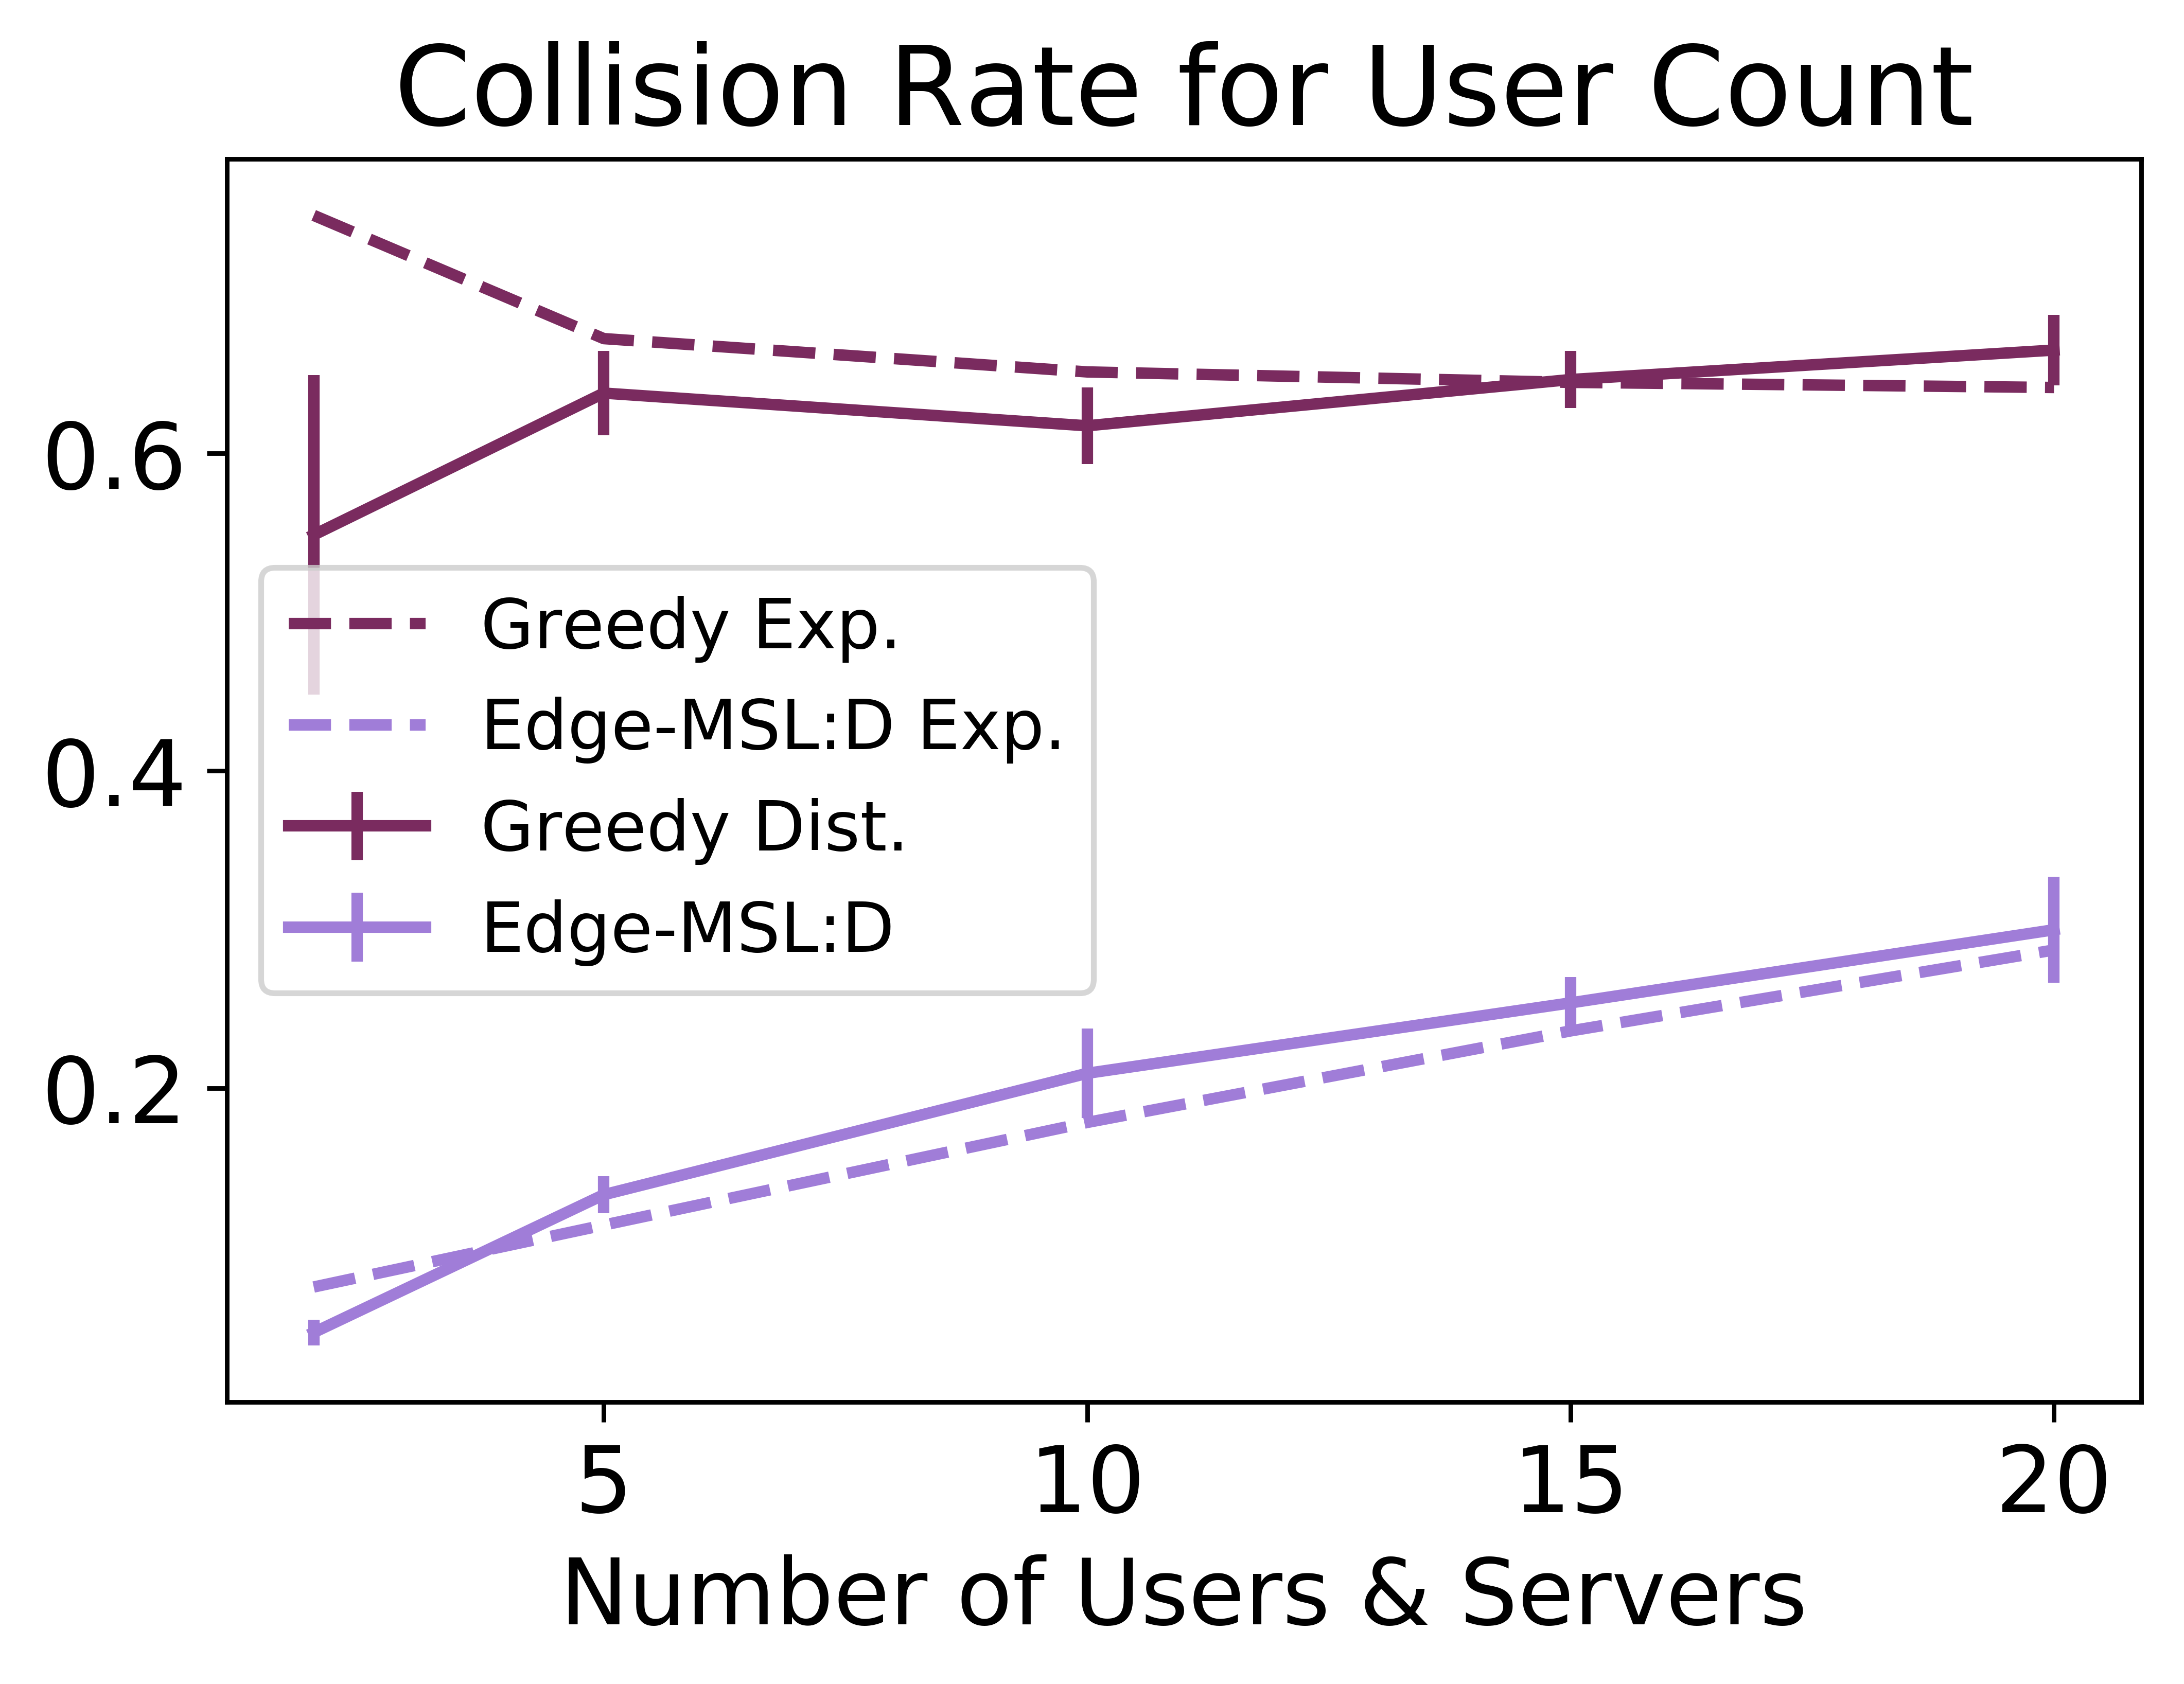

In [19]:
# Calculate from equation
pm = 0.05
pb = 0.5

# plt.plot(x,np.divide(coll_rsv_plot,num_svrs_list)/T, label = 'Reserve Dist.')
# plt.plot(x,np.divide(coll_worst_plot,num_svrs_list)/T, label = 'Greedy Dist.')
# plt.plot(x, exp_coll_greedy_list(num_svrs_list), label = "Greedy Exp.")
# plt.plot(x, coll_upr_rsv_list(pm, pb, num_svrs_list), label = "Reserve Upr")


# #  Set Font Size Limitations
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}
# matplotlib.rc('font', **font)


# plt.title('Cumulative Collision for Number of Users')
# plt.xlabel('Number of Users and Servers')
# plt.ylabel('')
# plt.legend()

plt.figure(figsize=(6, 4), dpi=800)
# Calculate from equation

plt.errorbar(x,np.divide(coll_worst_plot,num_svrs_list)/T, collisions_worst_sd2, 
             label = 'Greedy Dist.', color = np.divide(palette.colors[2],255), linewidth=2.0)
plt.errorbar(x,np.divide(coll_rsv_plot ,num_svrs_list)/T,collisions_rsv_sd2, 
             label = 'Edge-MSL:D', color = np.divide(palette.colors[4],255), linewidth=2.0)
plt.plot(x, exp_coll_greedy_list(num_svrs_list), label = "Greedy Exp.", color = np.divide(palette.colors[2],255), 
         linewidth=2.0, linestyle = 'dashed')
plt.plot(x, coll_upr_rsv_list(pm, pb, num_svrs_list), label = "Edge-MSL:D Exp.", 
        color = np.divide(palette.colors[4],255), linewidth=2.0, linestyle = 'dashed')

#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)


plt.title('Collision Rate for User Count')
plt.xlabel('Number of Users & Servers')
plt.legend(loc = 'center left', prop={'size': 12})


In [30]:
collisions_worst_sd

array([[1.04440000e+08, 9.97200000e+07, 1.49680000e+08, 9.64400000e+07,
        9.83000000e+07],
       [3.12599997e+00, 3.22389997e+00, 3.05239997e+00, 3.11429997e+00,
        3.43279997e+00],
       [2.95674999e+00, 3.22999998e+00, 3.18644998e+00, 2.93424999e+00,
        3.12684998e+00],
       [3.28476666e+00, 3.10383332e+00, 3.28983332e+00, 3.14696666e+00,
        3.33776666e+00],
       [3.51047499e+00, 3.20397499e+00, 3.21797499e+00, 3.36002499e+00,
        3.33452499e+00]])

In [31]:
coll_worst_dict_list

[{0: array([0., 0., 2., ..., 2., 2., 0.]),
  1: array([0., 0., 2., ..., 0., 0., 0.]),
  2: array([0., 0., 2., ..., 0., 0., 0.]),
  3: array([0., 0., 0., ..., 2., 2., 0.]),
  4: array([0., 0., 0., ..., 0., 0., 0.])},
 {0: array([0., 0., 0., ..., 3., 3., 0.]),
  1: array([0., 0., 0., ..., 4., 5., 0.]),
  2: array([0., 0., 0., ..., 2., 2., 0.]),
  3: array([0., 0., 0., ..., 2., 2., 0.]),
  4: array([0., 0., 0., ..., 4., 4., 0.])},
 {0: array([0., 0., 0., ..., 7., 7., 0.]),
  1: array([0., 0., 0., ..., 5., 5., 0.]),
  2: array([0., 0., 0., ..., 8., 7., 0.]),
  3: array([0., 0., 0., ..., 5., 5., 0.]),
  4: array([0., 0., 0., ..., 7., 7., 0.])},
 {0: array([ 0.,  0.,  0., ..., 10., 12.,  0.]),
  1: array([0., 0., 0., ..., 7., 8., 0.]),
  2: array([ 0.,  0.,  0., ..., 11., 11.,  0.]),
  3: array([ 0.,  0.,  0., ..., 11.,  9.,  0.]),
  4: array([ 0.,  0.,  0., ..., 12., 12.,  0.])},
 {0: array([ 0.,  0.,  0., ..., 12., 13.,  0.]),
  1: array([ 0.,  0.,  0., ..., 15., 16.,  0.]),
  2: array([ 0